<h2>Using SAS DLPy to Create Deep Learning Audio Models</h2>


You can use SAS DLPy to create, train, and deploy RNN models to process audio input for tasks such as speech recognition.

The example begins by configuring the computing environment by [importing required libraries and Python utilities](#importRequired). Then [connect to CAS](#casSWAT). 

The ultimate goal of this example to show that multiple steps: [process the audio data for modeling](#processAudio), [creating and loading an audio table](#createAudioTable), [extracting audio features](#extractAudio), [loading the audio metadata](#loadAudMeta), and [joining the audio and metadata features into a single table](#joinTable) can be done in a single call: [resulting single table](#resultingTable). 

With the model data ready, use DLPy to [create a speech recognition model](#createTrainAcoustic) and then [specify model parameters and train the model](#trainIt). Then use the trained speech recognition model to [score an audio table](#scoreAudioTable) .


<h3>Configure Environment: Import Required Libraries <a name="importRequired"></a></h3>

This part of the example configures your computing environment for speech recognition modeling using SAS DLPy and RNN networks. 

Begin by using `matplotlib inline` to configure the Python plot utility matplotlib to direct output to a Jupyter notebook cell. 

Import SWAT and DLPy, and then import the DLPy modules and functions required to create an RNN speech recognition model. Import the DLPy `Model` and `Sequential` classes and the `AudioTable` functions from the DLPy `audio` module. Import the `InputLayer`, `Conv2d`, `Pooling`, `Dense`, and `OutputLayer` functions from the DLPy `layers` module. These functions are required for the RNN model architecture. 

In [1]:
%matplotlib inline

# import SWAT and DLPy libraries and functions
import swat
import dlpy

from dlpy.audio import AudioTable 
from dlpy import Model
from dlpy import Sequential
 
from dlpy.layers import InputLayer
from dlpy.layers import Conv2d
from dlpy.layers import Pooling
from dlpy.layers import Dense
from dlpy.layers import OutputLayer

<h3>Connect to CAS and Load CAS DeepLearn Action Set <a name="casSWAT"></a></h3>

SAS DLPy requires a running SAS CAS server and Scripting Wrapper for Analytic Transfer (SWAT). The SWAT package is a Python interface to CAS. 

<b>Note:</b> For more information about starting a CAS session with the SWAT package, see https://sassoftware.github.io/python-swat/getting-started.html.


In [2]:
conn = swat.CAS(cashost, casport)

<h3>Process the Audio Data for Modeling <a name="processAudio"></a></h3>


Audio files need to be quantized into numeric vectors to be used in deep learning (or any other machine learning) algorithms. This quantization is basically representing audio waves with a set of audio descriptors (features).

<h3>Create Audio Table and Load Audio Files <a name="createAudioTable"></a></h3>

The first step to process the audio data is to create an audio table named `au`. Use the DLPy AudioTable `load_audio_files()` function to create the table `au` and to specify the path to the audio files list. Note that the listing file should be in the folder where the audio files live and the listing file should only contain the relative file names.

In [3]:
au = AudioTable.load_audio_files(conn, "/disk/lax_server_has_access/dlpy/listingFile.txt")

 Now use `fetch()` to display the contents of the toy audio table `au`. Table `au` is a "toy" table because it contains only 3 rows, but it is sufficient for the purposes of the model example. 

In [4]:
conn.table.fetch(au)

,_path_,_audio_
0,/disk/lax_server_has_access/dlpy/recording_1.wav,b'RIFF\xa4\xc7\x01\x00WAVEfmt \x10\x00\x00\x00...
1,/disk/lax_server_has_access/dlpy/recording_2.wav,b'RIFF\xa4W\x01\x00WAVEfmt \x10\x00\x00\x00\x0...
2,/disk/lax_server_has_access/dlpy/recording_3.wav,b'RIFF\xa4\xaf\x02\x00WAVEfmt \x10\x00\x00\x00...


The fetched audio table displays the path and audio data for three `.wav` audio files.

<h3>Extract Audio Features <a name="extractAudio"></a></h3>

Next, use the DLPy `AudioTable` `extract_audio_features()` function to extract audio features from the observations in the audio table and save the extracted feature table as `fp`. Extracting audio features consists of splitting the input audio signal into frames and computing a number of features for each frame. This creates a sequence of feature vectors for the whole signal.

The `copyVars` parameter in the function uses the value for `'_path_'` to specify the path to the .wav audio files in the `au` audio table. Then the files can be used to populate the `fp` audio features output table.





In [5]:
fp = AudioTable.extract_audio_features(conn, au, copyvars=['_path_'])

After creating audio feature table `fp` and populating the file with extracted audio features from the observations in table `au`, use `fetch()` to display the `fp` table and the frame contents for each unique `.wav` file listed in `_path_`.

In [6]:
conn.table.fetch(fp)

,_path_,_num_frames_,_f0_v0_,_f0_v1_,_f0_v2_,_f0_v3_,_f0_v4_,_f0_v5_,_f0_v6_,_f0_v7_,...,_f499_v31_,_f499_v32_,_f499_v33_,_f499_v34_,_f499_v35_,_f499_v36_,_f499_v37_,_f499_v38_,_f499_v39_,_fName_
0,/disk/lax_server_has_access/dlpy/recording_1.wav,362,-1.443214,0.052581,-0.788235,-0.214361,-0.160401,0.498287,1.178744,-0.199351,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,recording_1.wav
1,/disk/lax_server_has_access/dlpy/recording_2.wav,273,-0.939314,-0.114901,-0.027355,-0.041400,0.946150,0.818967,2.115959,0.806518,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,recording_2.wav
2,/disk/lax_server_has_access/dlpy/recording_3.wav,500,-1.098430,-0.667357,-0.802569,-0.368382,-0.742076,0.041933,-0.750673,-0.018975,...,-0.698485,0.664347,0.522895,0.456664,-0.892672,-1.084879,-0.595485,0.471108,0.083511,recording_3.wav


<h3>Load the Audio Metadata (Ground Truth)<a name="loadAudMeta"></a></h3>



Now load the audio metadata into an object named `me`. Use the `AudioTable` `load_audio_metadata()` function to create the table `me` and load the table. The specified function parameters in `load_audio_metadata()` include the connection object, the path and name to the input audio metadata (ground truth) file `groundTruth.txt`, and the path to the audio files.

DLPy uses `datasource/data_clean_replacement.txt` to cleanse the text in the `groundTruth.txt` file for DLPy formatting by replacing symbols with spaces or phrases.  In the case of audio, 'ground truth' refers to the actual contents of an audio file. For audio of a spoken voice, the ground truth for a spoken observation would be a text transcription of the spoken words. For audio of a song, the ground truth could consist of multiple instrument tracks and song lyrics. 

In [7]:
# Create CAS table 'me' and load audio metadata. Specify connection object, path to audio metadata
# (ground truth) file, and the path to the source audio files. 

me = AudioTable.load_audio_metadata(conn, 
                                    "/disk/lax_client_has_access/dlpy/groundTruth.txt",
                                    '/disk/lax_server_has_access/dlpy')

...using default replacements file from datasource dir
...reading in /ethem-kinginthenorth/python-dlpy/dlpy/datasources/data_clean_replacements.txt
...reading in /disk/lax_client_has_access/dlpy/groundTruth.txt
...warning, expression "[ ]{1,}" was NOT replaced with "&" in "bytearray(b"recording_1.wav\tHe made a sales call he says.\nrecording_2.wav\tIt wasn\'t a giveaway.\nrecording_3.wav\tThe gates and corridors were designed for smaller aircraft.\n")"
...found to the longest line with text length of 58
...The gates and corridors were designed for smaller aircraft
NOTE: Cloud Analytic Services made the uploaded file available as table AUDIOTABLE_METADATA_KHQGIA in caslib CASUSER(ethem-kinginthenorth).
NOTE: The table AUDIOTABLE_METADATA_KHQGIA has been created in caslib CASUSER(ethem-kinginthenorth) from binary data uploaded to Cloud Analytic Services.
...located newly created table AudioTable_Metadata_KHQgIa in caslib None 


Now use `fetch()` to display the contents of the newly crated audio metadata file `me`:

In [8]:
conn.table.fetch(me)

,_filename_,_path_,y0,y1,y10,y11,y12,y13,y14,y15,...,y54,y55,y56,y57,y6,y7,y8,y9,ylen,_fName_
0,recording_1.wav,/disk/lax_server_has_access/dlpy/recording_1.wav,H,e,s,a,l,e,s,~,...,~,~,~,~,e,~,a,~,28.0,recording_1.wav
1,recording_2.wav,/disk/lax_server_has_access/dlpy/recording_2.wav,I,t,a,~,g,i,v,e,...,~,~,~,~,n,',t,~,20.0,recording_2.wav
2,recording_3.wav,/disk/lax_server_has_access/dlpy/recording_3.wav,T,h,a,n,d,~,c,o,...,r,a,f,t,t,e,s,~,58.0,recording_3.wav


<h3>Join Audio and Metadata Features Together in a Single Table <a name="joinTable"></a></h3>

You currently have an audio features table `fp` and an audio metadata table `me`. Use `dlJoin()` to join the audio and metadata features together to create a new CAS output table named `test_features_withLabels`. 

The `dlJoin()` function parameters include the annotation table specification `me`, the data table specification `fp`, the observation identifier `id` (contained in the value stored for the unique observation `_path_`), and the name of the CAS output table `test_features_withLables`. 

In [9]:
conn.loadactionset('deeplearn')
conn.dlJoin(annotation=me,table=fp,id='_fName_',casOut=dict(name='test_features_withLabels'))

NOTE: Added action set 'deeplearn'.


,casLib,Name,Rows,Columns,casTable
0,CASUSER(ethem-kinginthenorth),test_features_withLabels,3,20063,"CASTable('test_features_withLabels', caslib='C..."


Now use `fetch()` to display the resulting joined table `test_features_withLabels` that contains combined audio and metadata features.

In [10]:
conn.table.fetch('test_features_withLabels')

,_fName_,_path_,_num_frames_,_f0_v0_,_f0_v1_,_f0_v2_,_f0_v3_,_f0_v4_,_f0_v5_,_f0_v6_,...,y53,y54,y55,y56,y57,y6,y7,y8,y9,ylen
0,recording_1.wav,/disk/lax_server_has_access/dlpy/recording_1.wav,362.0,-1.443214,0.052581,-0.788235,-0.214361,-0.160401,0.498287,1.178744,...,~,~,~,~,~,e,~,a,~,28.0
1,recording_2.wav,/disk/lax_server_has_access/dlpy/recording_2.wav,273.0,-0.939314,-0.114901,-0.027355,-0.041400,0.946150,0.818967,2.115959,...,~,~,~,~,~,n,',t,~,20.0
2,recording_3.wav,/disk/lax_server_has_access/dlpy/recording_3.wav,500.0,-1.098430,-0.667357,-0.802569,-0.368382,-0.742076,0.041933,-0.750673,...,c,r,a,f,t,t,e,s,~,58.0


<h3>Create an Audio Table using a Comprehensive Single Call</h3>

Thus far, the example has taken a stepwise approach to the process of creating an audio table to be used for speech recognition models. It is important to understand the audio table creation process as well as the purpose of the component tables used duing audio table creation.

The stepwise process to create an audio table is longer, but makes it more flexible. If you know what you are doing, you can use the stepwise approach. Alternatively, you can use a single and comprehensive call to do the same.

The follwing code uses the `AudioTable()` function from the DLPy `audio` class to create an audio table `au_table` by specifying the connection object `conn`, the path to the audio source files, and the path to the audio metadata  "ground truth" file.

In [12]:
from dlpy.audio import AudioTable


au_table = AudioTable.create_audio_table(conn,
                                  "/disk/lax_server_has_access/dlpy/listingFile.txt",
                                  "/disk/lax_client_has_access/dlpy/groundTruth.txt")

...using default replacements file from datasource dir
...reading in /ethem-kinginthenorth/python-dlpy/dlpy/datasources/data_clean_replacements.txt
...reading in /disk/lax_client_has_access/dlpy/groundTruth.txt
...warning, expression "[ ]{1,}" was NOT replaced with "&" in "bytearray(b"recording_1.wav\tHe made a sales call he says.\nrecording_2.wav\tIt wasn\'t a giveaway.\nrecording_3.wav\tThe gates and corridors were designed for smaller aircraft.\n")"
...found to the longest line with text length of 58
...The gates and corridors were designed for smaller aircraft
NOTE: Cloud Analytic Services made the uploaded file available as table AUDIOTABLE_METADATA_USVES3 in caslib CASUSER(ethem-kinginthenorth).
NOTE: The table AUDIOTABLE_METADATA_USVES3 has been created in caslib CASUSER(ethem-kinginthenorth) from binary data uploaded to Cloud Analytic Services.
...located newly created table AudioTable_Metadata_USVes3 in caslib None 


Now use `fetch()` to display the contents of the new audio table that was created using the compact code:

In [13]:
conn.table.fetch(au_table)

,_fName_,_path_,_num_frames_,_f0_v0_,_f0_v1_,_f0_v2_,_f0_v3_,_f0_v4_,_f0_v5_,_f0_v6_,...,y53,y54,y55,y56,y57,y6,y7,y8,y9,ylen
0,recording_1.wav,/disk/lax_server_has_access/dlpy/recording_1.wav,362,-1.440627,0.059566,-0.838013,-0.133665,-0.106268,0.457815,1.178379,...,~,~,~,~,~,e,~,a,~,28.0
1,recording_2.wav,/disk/lax_server_has_access/dlpy/recording_2.wav,273,-0.940642,-0.099421,-0.108645,0.059823,0.787028,0.827834,2.111820,...,~,~,~,~,~,n,',t,~,20.0
2,recording_3.wav,/disk/lax_server_has_access/dlpy/recording_3.wav,500,-1.098440,-0.667745,-0.802858,-0.362663,-0.722804,0.041250,-0.711174,...,c,r,a,f,t,t,e,s,~,58.0


The contents of the audio table `au` created using the multi-step process and the contents of the audio table `au_table` created using the single step process are identical.

<h3>Create a Speech Recognition Model <a name="createTrainAcoustic"></a></h3>




Now that you have an audio table ready for modeling, use DLPy to create and train an RNN model to perform speech recognition.

First, ensure that you have the required library classes and functions for the task.

The following code imports the `SpeechRecognition` functions from the DLPy `applications` class, imports `StringIO` functions from the `io` class, imports the SWAT data handler module as `dmh`, and imports the `TextParms`, `DataSpec`, and `DataSpecNumNomOpts` functions from the DLPy `model` class.

In [14]:
from dlpy.applications import SpeechRecognition
# Exception handler for reading StringIO text data into memory
try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO
import swat.cas.datamsghandlers as dmh
from dlpy.model import TextParms, DataSpec, DataSpecNumNomOpts

Now use the DLPy `SpeechRecognition()` function to create an acoustic RNN model named `model`, with 15 neurons and one bi-directional block:

In [15]:
# create an acoustic model
model = SpeechRecognition(conn, neurons=15, n_blocks=1)

NOTE: Output layer added.
NOTE: Model compiled successfully.


Use the Graphviz `plot_network()` function to display a plot of the network DAG (Direct Acyclic Graph):

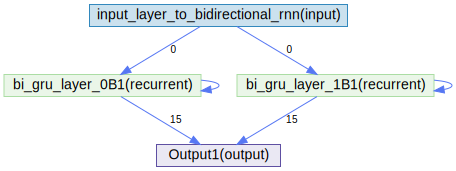

In [16]:
model.plot_network()

The following code establishes naming conventions for the audio table columns containing sequential frame `f` and value `v` pairs. This generates column names such as`_f0_v0_`, `_f0_v1_`,` _f0_v2_`... and so on. These are matching the columns names in the audio table and will be used as inputs. Columns `y0`, `y1`, and so on will be the target values.

In [17]:
inputVars = []
targetVars = []
for f in range(0,500):
    for v in range(0,40):
        colName = '_f' + str(f) + '_v' + str(v) + '_'
        inputVars.append(colName)
for t in range(0,57):
    colName = 'y' + str(t)
    targetVars.append(colName)

<h3>Specify Model Parameters and Train the Acoustic Speech Recognition Model <a name="trainIt"</a></h3>

Now use `fit()` to train the RNN acoustic speech recognition model `model` using the data in audio table `au_table`. The RNN model uses `numericnominal` input and output layers, trains for a maximum of 5 epochs, and has a learning rate of 0.001. The `log_level=2` specification provides basic model log details.

In [18]:
# Training acoustic model
# dataspec layers should be the same as the layer names in the model
model.fit(data=au_table, 
          data_specs=[DataSpec(type_='numericnominal', 
                               layer='input_layer_to_bidirectional_rnn', 
                               data=inputVars, 
                               numeric_nominal_parms=DataSpecNumNomOpts(token_size=40, length='_num_frames_')), 
                     DataSpec(type_='numericnominal', 
                              layer='Output1', 
                              data=targetVars, 
                              numeric_nominal_parms=DataSpecNumNomOpts(token_size=1,length='ylen'))],
          max_epochs=5, 
          log_level=2,
          lr=0.001)

NOTE: Training from scratch.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 5784.
NOTE:  The approximate memory cost is 61.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       0.11 (s).
NOTE:  The total number of threads on each worker is 56.
NOTE:  The total mini-batch size per thread on each worker is 1.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 56.
NOTE:  Target variable: y0
NOTE:  Number of levels for the target variable:     24
NOTE:  Levels for the target variable:
NOTE:  Level      0: '
NOTE:  Level      1: ~
NOTE:  Level      2: a
NOTE:  Level      3: c
NOTE:  Level      4: d
NOTE:  Level      5: e
NOTE:  Level      6: f
NOTE:  Level      7: g
NOTE:  Level      8: h
NOTE:  Level      9: H
NOTE:  Level     10: i
NOTE:  Level     11: I
NOTE:  Level     12: l
NOTE:  Level     13: m
NOTE:  Level     14: n
NOTE:  Level     15: o
NOTE:  Level     16: r
NOTE:  Level     17: s


,Descr,Value
0,Model Name,acoustic_model
1,Model Type,Recurrent Neural Network
2,Number of Layers,4
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,0
6,Number of Pooling Layers,0
7,Number of Fully Connected Layers,0
8,Number of Recurrent Layers,2
9,Number of Weight Parameters,5670


The trained model `model` consists of multiple layers: 1 input layer, 1 bi-directional block (2 recurrent layers), and 1 output layer. After 5 epochs, the trained model with 5,784 parameters.

<h3>Use Trained Speech Recognition Model to Score Audio Table <a name="scoreAudioTable"></a></h3>

Now use the `predict()` function with the trained RNN model `model` to score the audio table `au_table`. The score task seeks to generate textual character transcriptions for the audio features in the modeled data.

In [19]:
# run RNN scoring to get character transcriptions for the audio features
model.predict(data=au_table)
model.valid_res_tbl.fetch(to=2)

NOTE: Due to data distribution, miniBatchSize has been limited to 3.


,_fName_,_path_,_num_frames_,_f0_v0_,_f0_v1_,_f0_v2_,_f0_v3_,_f0_v4_,_f0_v5_,_f0_v6_,...,_DL_P499_17_,_DL_P499_18_,_DL_P499_19_,_DL_P499_20_,_DL_P499_21_,_DL_P499_22_,_DL_P499_23_,_DL_PredName499_,_DL_PredP499_,_DL_PredLevel499_
0,recording_1.wav,/disk/lax_server_has_access/dlpy/recording_1.wav,362,-1.440627,0.059566,-0.838013,-0.133665,-0.106268,0.457815,1.178379,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,0.0,-1.0
1,recording_2.wav,/disk/lax_server_has_access/dlpy/recording_2.wav,273,-0.940642,-0.099421,-0.108645,0.059823,0.787028,0.827834,2.111820,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,0.0,-1.0


After having raw predictions, they are usually post-processed (language modelling) to rectify the results. 